In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  9 14:12:53 2017

@author: charles
"""

import pickle
import numpy as np

import numpy as np
import sklearn
from scipy.stats import chi2 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

### read and normalize data

In [9]:
X = np.load('./data/obs.npy')
X /= X.max(axis=0)
y = pickle.load( open( "./data/labels.pkl", "rb" ) )
y = np.array(y)
nsamples, nfeatures = X.shape

-0.2336134007825152 1.0


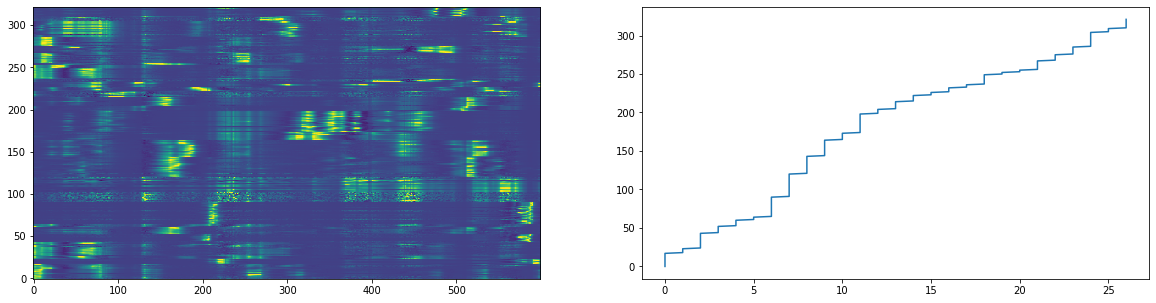

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.imshow(X, origin='lower', aspect='auto')
ax2.plot(y, list(range(len(y))))
print(X.min(), X.max())

### compute mean spectra and variances

In [59]:
nlabels = len(np.unique(y))
print(nlabels)

27


In [60]:
mean_spectra = np.vstack([ np.mean(X[iclass==y], axis=0) for iclass in range(nlabels) ])
var_spectra = np.vstack([ np.var(X[iclass==y], axis=0) for iclass in range(nlabels) ])

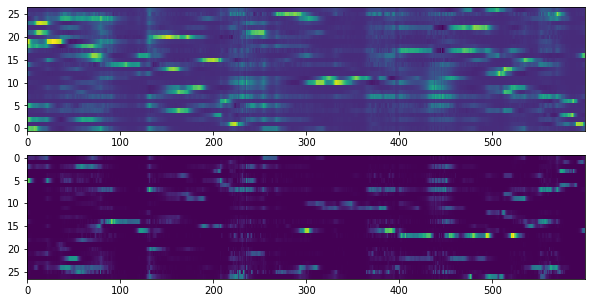

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.imshow(mean_spectra, origin='lower', aspect='auto')
ax2.imshow(var_spectra, aspect='auto')

### prepare synthetic data

In [68]:
nsynt = 10
synt_y = np.random.binomial(1, p=3./27., size=(nsynt, nlabels))

In [69]:
synt_X = np.zeros((nsynt, nfeatures))

for isample, mixture in enumerate(synt_y):
    for iclass, weight in enumerate(mixture):
        class_spectra = X[np.array(y) == iclass]
        ispec = np.random.choice(len(class_spectra))
        synt_X[isample] += weight * class_spectra[ispec]

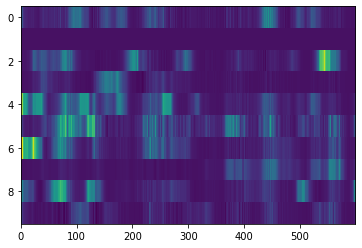

In [70]:
plt.figure()
plt.imshow(synt_X, aspect='auto')

(600,)


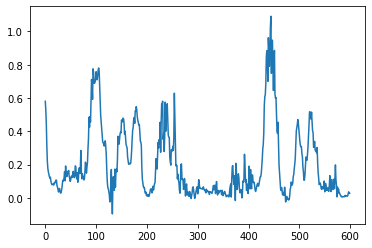

In [78]:
observation = synt_X[0]
print(observation.shape)
plt.plot(observation)

### likelihood model

In [81]:
import pymc3 as pm

def logp(params: np.array, spectrum_observed: np.array) -> float:
    probaility_iclass_ipoint = np.exp(-(spectrum_observed - mean_spectra)**2/(0.5* var_spectra**2))
    likelihood = np.sum(np.log(np.sum(params[:, None] * , axis=0)))
    return likelihood

In [ ]:
with pm.Model() as model:
    params = np.as_array([pm.Binomial(1, p=3./27.) for iclass in range(nlabels)])
    exp_surv = pm.DensityDist('exp_surv', logp, observed={'failure':, ''})
    
    # sigma = HalfCauchy('sigma', beta=10, testval=1.)
    likelihood = Normal('y', mu=intercept + x_coeff * x, sigma=sigma, observed=y)

    # Inference!
    trace = sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling